In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

import pymc3 as pm
import arviz as az
import patsy
from pymc3 import glm
from pymc3 import distributions as pm_dists

plt.rcParams['figure.figsize'] = [7, 6]
plt.rcParams['figure.dpi'] = 100

In [2]:
np.random.seed(1)

n = 200

x1 = np.random.normal(loc=0.0, scale=2.0, size=n)
x2 = np.random.normal(loc=0.0, scale=2.0, size=n)
epsilon = np.random.normal(loc=0.0, scale=0.5, size=n)

z = x1 - x2 + 2*x1*x2 - 0.5 + epsilon
p = 1 / (1 + np.exp(-z))
y = (p >= 0.5).astype(int)

df = pd.DataFrame(dict(x1=x1, x2=x2, y=y))

df.head()

,x1,x2,y
0,3.248691,-0.801756,0
1,-1.223513,1.648011,0
2,-1.056344,-1.124611,1
3,-2.145937,3.909756,0
4,1.730815,-2.663903,0


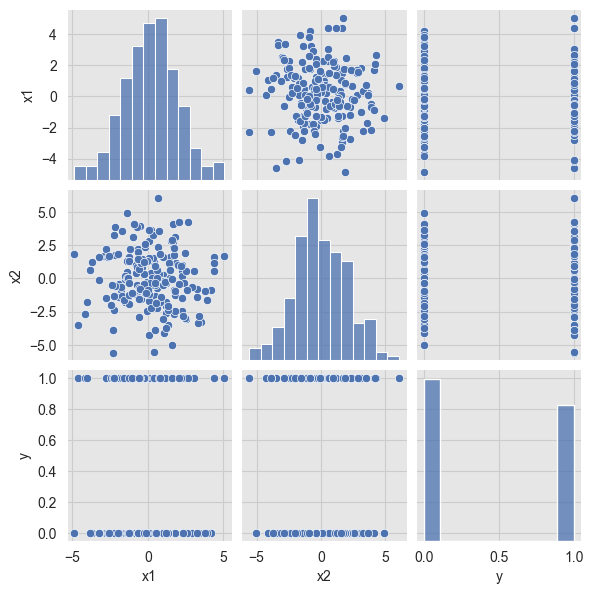

In [3]:
sns.pairplot(data=df, height=2);

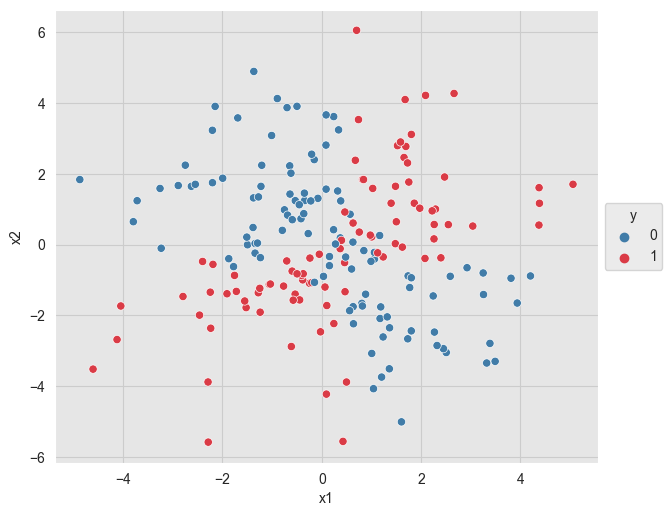

In [4]:
fig, ax = plt.subplots()
sns_c_div = sns.diverging_palette(240, 10, n=2)
sns.scatterplot(x='x1', y='x2', data=df, hue='y', palette=[sns_c_div[0], sns_c_div[-1]])
ax.legend(title='y', loc='center left', bbox_to_anchor=(1, 0.5));

In [5]:
formula = 'y ~ x1 * x2'

y, x = patsy.dmatrices(formula_like=formula, data=df)
y = np.asarray(y).flatten()
labels = x.design_info.column_names
x = np.asarray(x)
labels

['Intercept', 'x1', 'x2', 'x1:x2']

In [6]:
prop_train = 0.7
n_train = round(prop_train * n)

x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:]
y_test = y[n_train:]

In [7]:
with pm.Model() as model:

    data = pm.Data('data', x_train)

    family = pm.glm.families.Binomial()

    glm.GLM(
        y=y_train,
        x=data,
        family=family, 
        intercept=False,
        labels=labels,
        priors={
            'x1': pm.Normal.dist(mu=0, sd=20),
            'x2': pm.Normal.dist(mu=0, sd=20),
            'x1:x2': pm.Normal.dist(mu=0, sd=20),
            'Intercept': pm.Normal.dist(mu=0, sd=20)
        }
    )

    trace = pm.sample(2000, chains=5, tune=2000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [x1:x2, x2, x1, Intercept]


Sampling 5 chains for 2_000 tune and 2_000 draw iterations (10_000 + 10_000 draws total) took 24 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7014520255688215, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6591953114284891, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


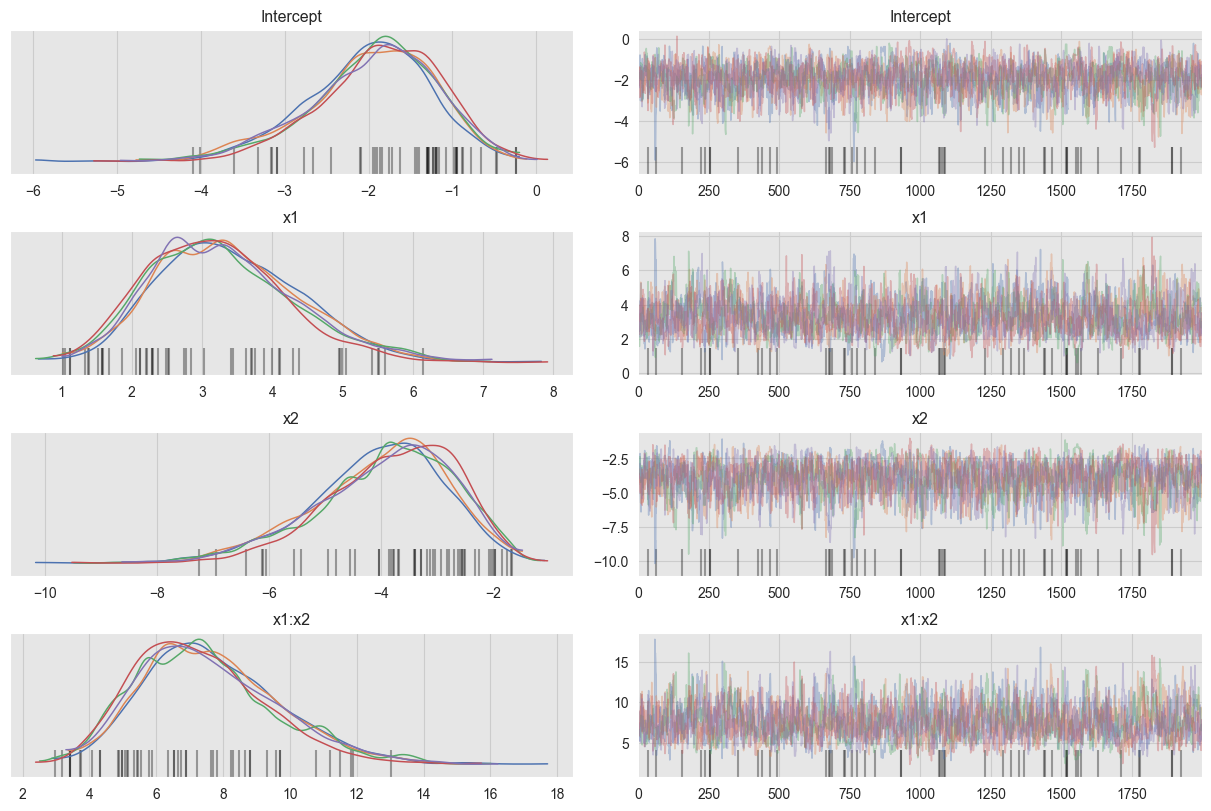

In [8]:
az.plot_trace(trace);

In [9]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.941,0.751,-3.410,-0.612,0.020,0.014,1392.0,1392.0,1374.0,2172.0,1.01
x1,3.314,1.029,1.491,5.287,0.031,0.022,1133.0,1133.0,1102.0,1827.0,1.01
x2,-3.954,1.223,-6.198,-1.751,0.036,0.025,1161.0,1161.0,1140.0,1992.0,1.01
x1:x2,7.536,2.064,3.849,11.351,0.063,0.044,1089.0,1089.0,1058.0,1856.0,1.01


In [10]:
pm.set_data({'data': x_test}, model=model)
ppc_test = pm.sample_posterior_predictive(trace, model=model, samples=1000)

In [11]:
p_test_pred = ppc_test['y'].mean(axis=0)
y_test_pred = (p_test_pred >= 0.5).astype('int')

In [12]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true=y_test, y_pred=y_test_pred)

0.9

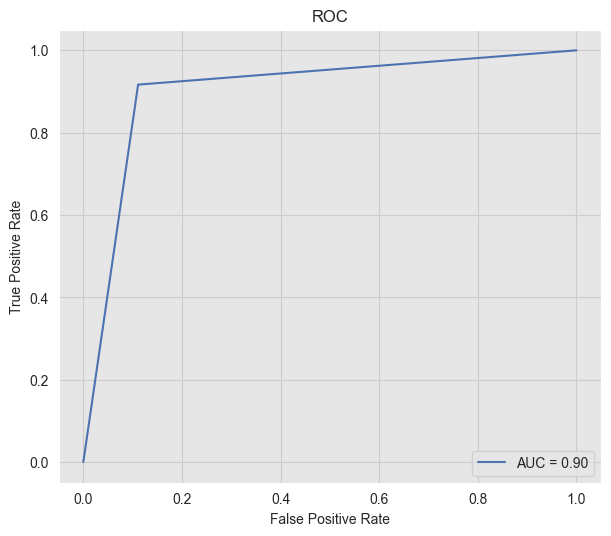

In [13]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_test_pred, pos_label=1, drop_intermediate=False)
roc_auc = auc(fpr, tpr)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
ax = roc_display.ax_
ax.set(title='ROC');

In [14]:
x1_grid = np.linspace(start=-7, stop=7, num=100)
x2_grid = x1_grid

x1_mesh, x2_mesh = np.meshgrid(x1_grid, x2_grid)

x_grid = np.stack(arrays=[x1_mesh.flatten(), x2_mesh.flatten()], axis=1)

x_grid_ext = patsy.dmatrix(
    formula_like='x1 * x2', 
    data=dict(x1=x_grid[:, 0], x2=x_grid[:, 1])
)

x_grid_ext = np.asarray(x_grid_ext)

pm.set_data({'data': x_grid_ext}, model=model)
ppc_grid = pm.sample_posterior_predictive(trace, model=model, samples=1000)

In [15]:
grid_df = pd.DataFrame(x_grid, columns=['x1', 'x2'])
grid_df['p'] = ppc_grid['y'].mean(axis=0)
grid_df.sort_values('p', inplace=True)

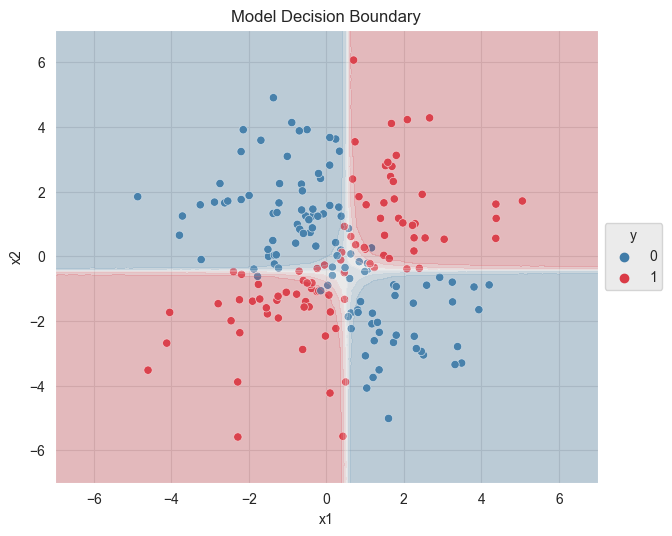

In [16]:
p_grid = grid_df \
    .pivot(index='x2', columns='x1', values='p') \
    .to_numpy()

fig, ax = plt.subplots()
cmap = sns.diverging_palette(240, 10, n=50, as_cmap=True)
sns.scatterplot(x='x1', y='x2', data=df, hue='y', palette=[sns_c_div[0], sns_c_div[-1]], ax=ax)
ax.contourf(x1_grid, x2_grid, p_grid, cmap=cmap, alpha=0.3)
ax.legend(title='y', loc='center left', bbox_to_anchor=(1, 0.5));
ax.set(title='Model Decision Boundary');